In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
measurement_data = engine.execute('SELECT * FROM measurement')
print(measurement_data.keys())

['id', 'station', 'date', 'prcp', 'tobs']


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


The last data point is ('2017-08-23',)


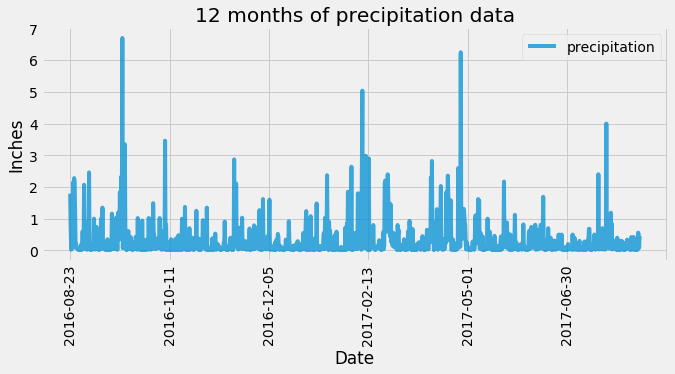

In [167]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastdatapoint = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The last data point is {lastdatapoint}')

# Perform a query to retrieve the data and precipitation scores
oneyeardata = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_Measurement12months = pd.DataFrame(oneyeardata, columns = ['date','precipitation'])
df_Measurement12months.set_index('date', inplace=True, drop=True)
df_Measurement12_clean = df_Measurement12months.dropna()
df_Measurement12_clean = df_Measurement12_clean.loc[(df_Measurement12_clean!=0).any(axis=1)]

# Sort the dataframe by date
df_Measurement12_clean = df_Measurement12_clean.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data 
df_Measurement12_clean.plot(kind="line", figsize=(10,4),alpha=0.75, rot=90)
plt.title("12 months of precipitation data")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [419]:
df_Measurement12_clean

,precipitation
date,
2016-08-23,1.79
2016-08-23,0.70
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-21,0.02
2017-08-21,0.56
2017-08-22,0.50


In [156]:
# Use Pandas to calcualte the summary statistics for the precipitation data
statistics =  pd.DataFrame(df_Measurement12_clean['precipitation'].describe())
statistics

,precipitation
count,1147.000000
mean,0.312363
std,0.576781
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_data = engine.execute('SELECT * FROM station')
num_station = session.query(Station.station).distinct().count()
print(f'There are {num_station} stations available')

There are 9 stations available


In [116]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations_data = session.query(Measurement.station, Measurement.date).all()
df_active_stations = pd.DataFrame(active_stations_data, columns = ['station','count_of_stations'])
df_active_stations = df_active_stations.dropna()
df_active_stations = df_active_stations.groupby(['station']).count().sort_values(by='count_of_stations', ascending=False)
df_active_stations

,count_of_stations
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [117]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
tobs_station_data = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281').all()
df_temperature = pd.DataFrame(tobs_station_data, columns = ['station','temperature'])
df_temperature.set_index('station', inplace=True, drop=True)
min_temp = df_temperature.min()
min_temp
max_temp = df_temperature.max()
mean_temp = df_temperature.mean()
print(f'The lowest temperature recorded is {min_temp}')
print(f'The highest temperature recorded is {max_temp}')
print(f'The average temperature recorded is {mean_temp}')

The lowest temperature recorded is temperature    54.0
dtype: float64
The highest temperature recorded is temperature    85.0
dtype: float64
The average temperature recorded is temperature    71.663781
dtype: float64


The station with the highest number of temperature observations is USC00519281


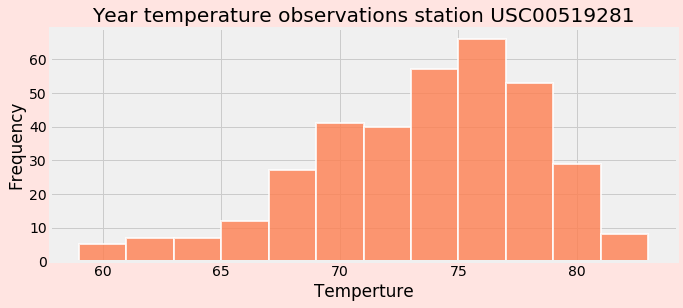

In [132]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.station, Measurement.tobs).all()
df_num_tobs = pd.DataFrame(tobs_data, columns = ['station','count_of_tobs'])
df_num_tobs = df_num_tobs.dropna()
df_num_tobs = df_num_tobs.groupby(['station']).count().sort_values(by='count_of_tobs', ascending=False)
df_num_tobs = df_num_tobs.reset_index()
df_num_tobs = df_num_tobs['station'].iloc[0]
print(f'The station with the highest number of temperature observations is {df_num_tobs}')

oneyeardata = session.query(Measurement.station, Measurement.tobs, Measurement.date).\
                filter(Measurement.date >= '2016-08-23').\
                filter(Measurement.station == 'USC00519281').all()
df_temperature_onestation = pd.DataFrame(oneyeardata, columns = ['station','temperature','date'])

plt.figure(figsize=(10,4),facecolor='mistyrose')
plt.hist(df_temperature_onestation['temperature'], 12, color='coral', alpha=0.8, edgecolor='white', linewidth=2)
plt.title("Year temperature observations station USC00519281")
plt.xlabel('Temperture')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [168]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [172]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


<Figure size 144x288 with 0 Axes>

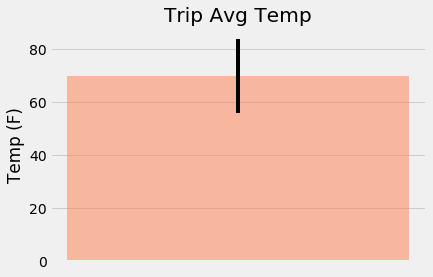

In [207]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

xvalue = np.arange(1)
yvalue = 69.75510204081633
error = 75.0 - 61.0
fig1, ax1 = plt.subplots()
ax1.set_title('Trip Avg Temp')
ax1.set_ylabel('Temp (F)')
ax1.bar(xvalue, yvalue, yerr=error, align='center', color='coral', alpha=0.5, ecolor='black')
ax1.set_xticks([])
plt.show()

In [221]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, func.sum(Measurement.tobs), Station.name, Station.latitude, Station.longitude, Station.elevation).\
            filter(Measurement.date >= '2011-02-28').\
            filter(Measurement.date <='2011-03-05').\
            group_by(Measurement.station).\
            order_by(Measurement.tobs.desc()).\
            filter(Measurement.station == Station.station).all()
df_rainfall = pd.DataFrame(rainfall, columns = ['station','rainfall','name','latitud','longitude','elevation'])
df_rainfall

,station,rainfall,name,latitud,longitude,elevation
0,USC00516128,422.0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00518838,366.0,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
2,USC00519523,421.0,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00514830,419.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00513117,418.0,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,USC00517948,208.0,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,USC00519397,423.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
7,USC00519281,406.0,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
8,USC00511918,335.0,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


In [222]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [388]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start='2011-02-28'
end='2011-03-05'

# Use the start and end date to create a range of dates
daterange = pd.date_range(start, end)

# Stip off the year and save a list of %m-%d strings
date_range = daterange.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
results_dailynormals = []
for date in date_range:
    results_dailynormals.append((daily_normals(date)[0]))

In [415]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_dailynormals = pd.DataFrame(results_dailynormals, columns =['Min', 'Avg', 'Max'])#, index = daterange) 
df_dailynormals

,Min,Avg,Max
0,65.0,70.655172,80.0
1,64.0,70.032787,76.0
2,61.0,70.366667,78.0
3,60.0,70.068966,78.0
4,57.0,69.272727,77.0
5,60.0,67.890909,76.0


[Text(0, 0, '11/02/28'),
 Text(0, 0, '11/03/01'),
 Text(0, 0, '11/03/02'),
 Text(0, 0, '11/03/03'),
 Text(0, 0, '11/03/04'),
 Text(0, 0, '11/03/05')]

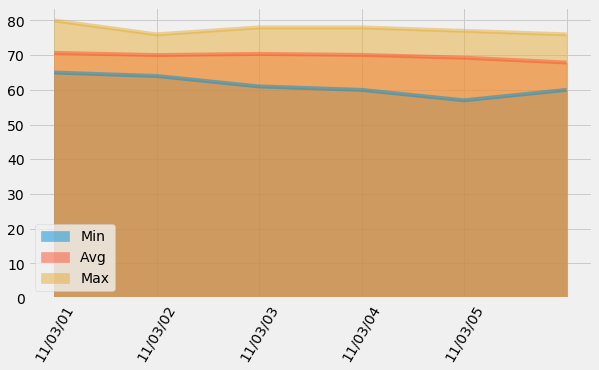

In [418]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df_dailynormals.plot.area(stacked=False, figsize=(9,5), rot=60)
ax.set_xticklabels(daterange.strftime("%y/%m/%d"))